In [223]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [224]:
data = pd.read_csv('credit_data.csv')

In [225]:
data = data.set_index('clientid')

array([[<Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'loan'}>,
        <Axes: title={'center': 'default'}>]], dtype=object)

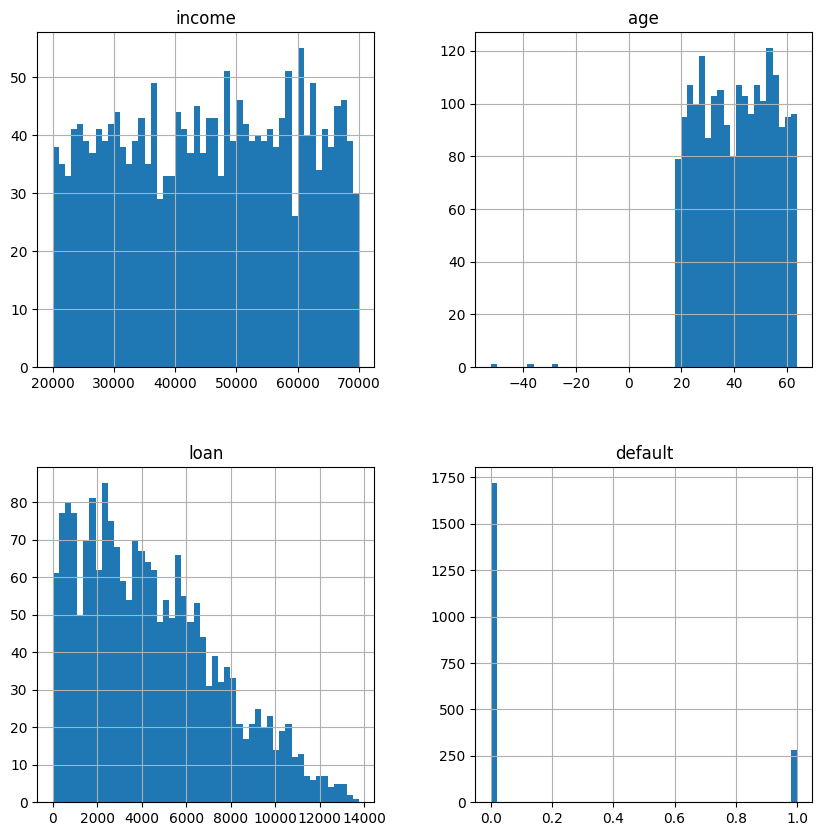

In [226]:
data.hist(bins = 50, figsize = (10,10))

In [227]:
data.corr()

,income,age,loan,default
income,1.000000,-0.033687,0.441117,0.002284
age,-0.033687,1.000000,0.002309,-0.429759
loan,0.441117,0.002309,1.000000,0.377160
default,0.002284,-0.429759,0.377160,1.000000


In [228]:
data = data[data['age']>0]

array([[<Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'loan'}>,
        <Axes: title={'center': 'default'}>]], dtype=object)

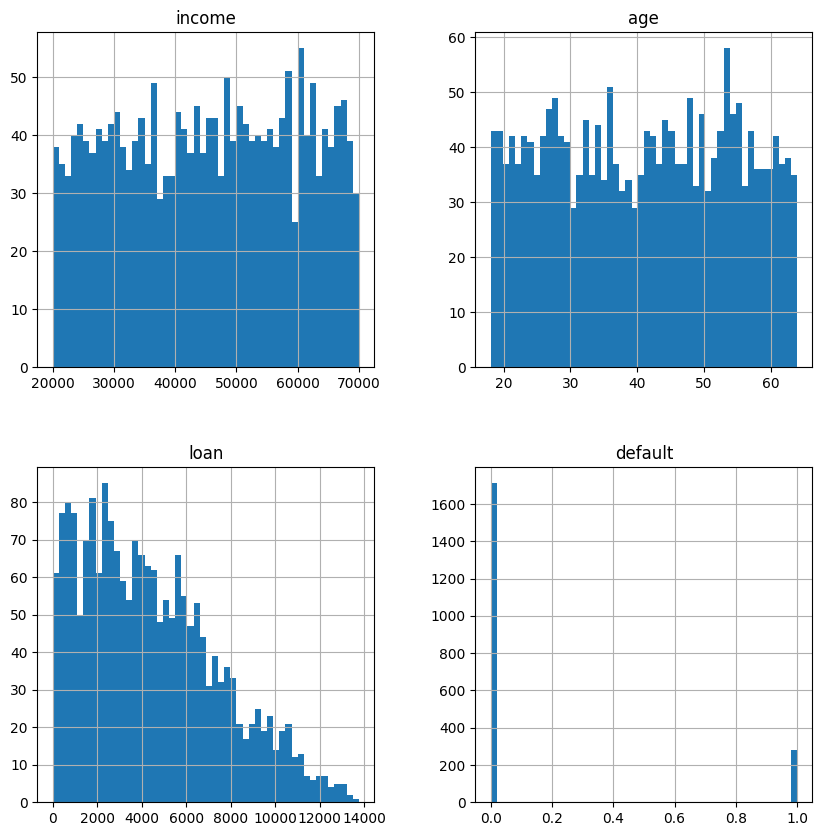

In [229]:
data.hist(bins = 50, figsize = (10,10))

<Axes: xlabel='default', ylabel='age'>

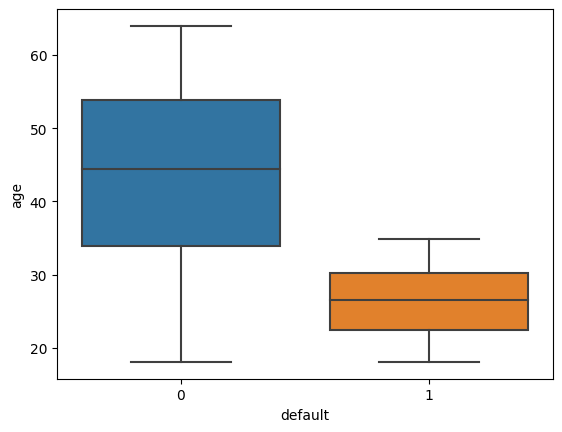

In [230]:
sns.boxplot(x = 'default',y = 'age',data = data)

<Axes: xlabel='default', ylabel='income'>

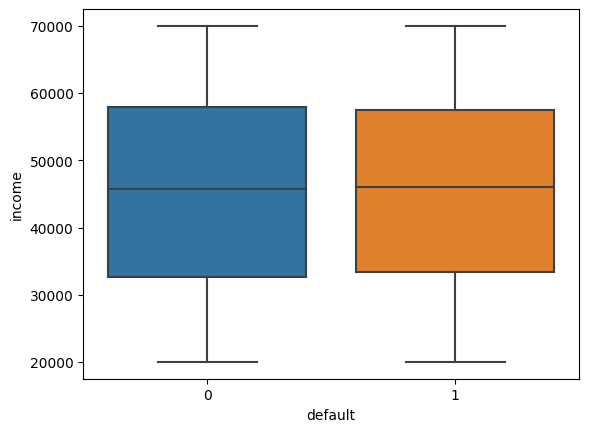

In [231]:
sns.boxplot(x = 'default',y = 'income',data = data)

<Axes: xlabel='default', ylabel='loan'>

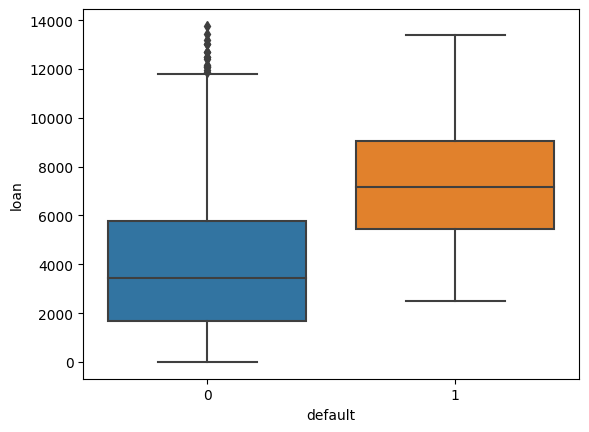

In [232]:
sns.boxplot(x = 'default',y = 'loan',data = data)

<Axes: xlabel='income', ylabel='loan'>

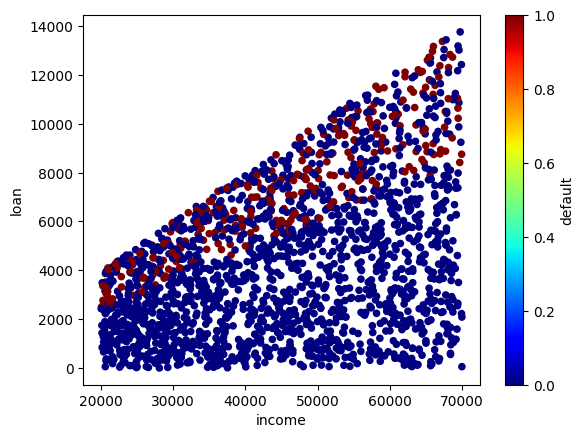

In [233]:
data.plot(kind = 'scatter',x = 'income',y='loan',c = 'default', cmap = plt.get_cmap("jet"))

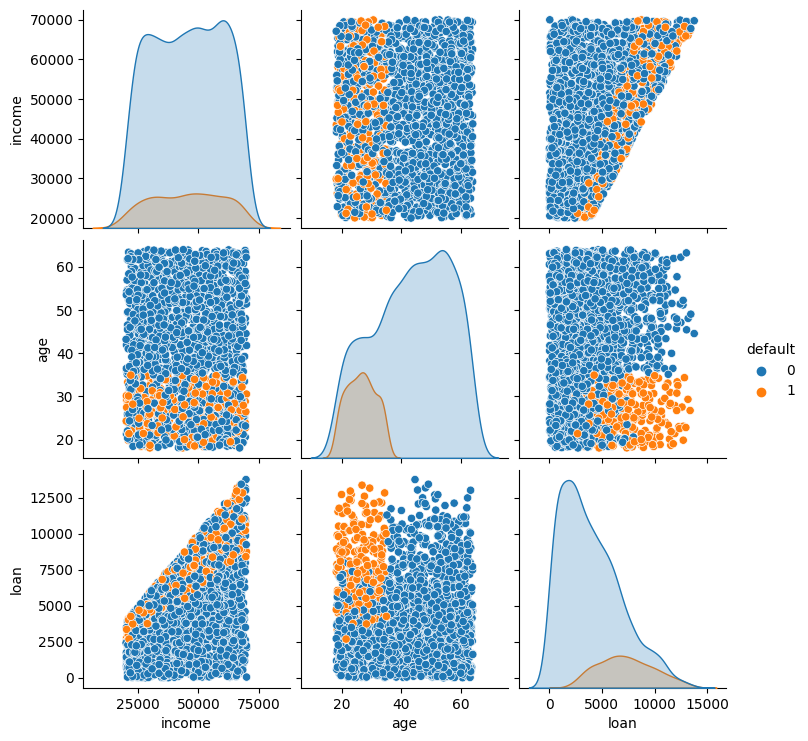

In [234]:
sns.pairplot(data,hue = "default")

In [235]:
data['default'].value_counts()/len(data)*100

default
0    85.807422
1    14.192578
Name: count, dtype: float64

In [236]:
data.isna().sum()

income     0
age        0
loan       0
default    0
dtype: int64

In [237]:
data['ratio'] = data['loan']/data['income']
data['difference'] = data['loan'] - data['income']

<Axes: xlabel='ratio', ylabel='Count'>

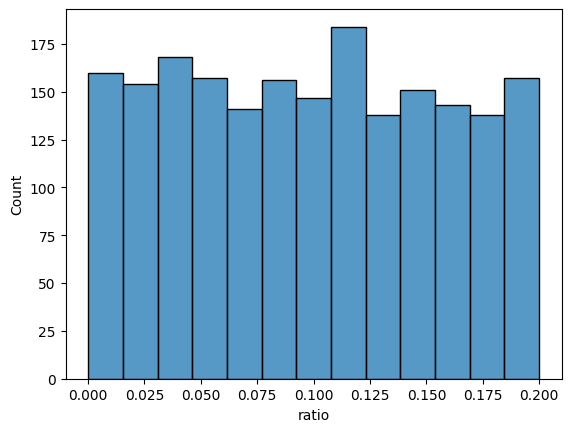

In [238]:
sns.histplot(data['ratio'])

<Axes: xlabel='default', ylabel='ratio'>

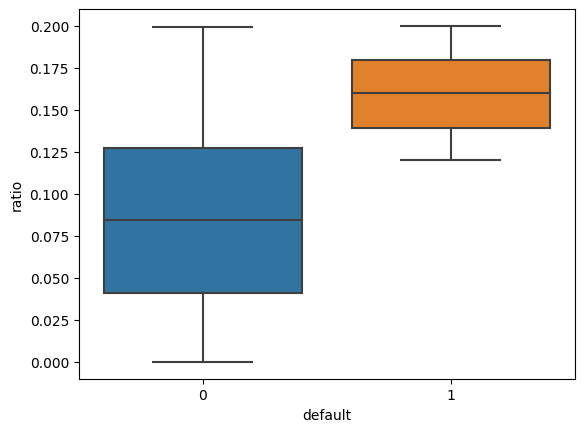

In [239]:
sns.boxplot(x = 'default',y = 'ratio',data = data)

In [240]:
data.corr()

,income,age,loan,default,ratio,difference
income,1.000000,-0.033256,0.441074,0.002366,-0.019364,-0.978531
age,-0.033256,1.000000,0.006686,-0.445248,0.020710,0.037446
loan,0.441074,0.006686,1.000000,0.377789,0.847730,-0.246636
default,0.002366,-0.445248,0.377789,1.000000,0.433881,0.084203
ratio,-0.019364,0.020710,0.847730,0.433881,1.000000,0.215587
difference,-0.978531,0.037446,-0.246636,0.084203,0.215587,1.000000


In [241]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.33,random_state=None)

In [242]:
for train_index, test_index in sss.split(data.drop('default',axis= 1),data['default']):
    train = data.iloc[train_index]
    test = data.iloc[test_index]

In [243]:
X_train = train.drop('default',axis= 1)
y_train = train['default']

X_test = test.drop('default',axis= 1)
y_test = test['default']

In [177]:
import pandas as pd
import urllib
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
import time
from urllib.request import urlretrieve

def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree):

    params = {'objective': 'binary:logistic',
              'max_depth': int(max_depth),
              'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree}
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, early_stopping_rounds=10, nfold=5, metrics='error')
    return -cv_result['test-error-mean'].iloc[-1]

pbounds = {'max_depth': (3, 10),
           'learning_rate': (0.01, 0.5),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1)}

print('Performing hyperparameter tuning using Bayesian optimization...')
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=1)
optimizer.maximize(init_points=5, n_iter=40)

print('Training the XGBoost model with the best hyperparameters from Bayesian optimization...')

params = {'objective': 'binary:logistic',
          'max_depth': int(optimizer.max['params']['max_depth']),
          'learning_rate': optimizer.max['params']['learning_rate'],
          'subsample': optimizer.max['params']['subsample'],
          'colsample_bytree':optimizer.max['params']['colsample_bytree']}
          
print('Making predictions on the test set...')

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train,y_train)

# dtest = xgb.DMatrix(X_test)
y_pred = xgb_model.predict(X_test)
# y_pred = [int(round(value)) for value in y_pred]

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))


Performing hyperparameter tuning using Bayesian optimization...
|   iter    |  target   | colsam... | learni... | max_depth | subsample |
-------------------------------------------------------------------------
| 1         | -0.04494  | 0.4753    | 0.363     | 3.001     | 0.3721    |
| 2         | -0.1378   | 0.2321    | 0.05525   | 4.304     | 0.411     |
| 3         | -0.04569  | 0.4571    | 0.274     | 5.934     | 0.7167    |
| 4         | -0.03296  | 0.284     | 0.4403    | 3.192     | 0.7034    |
| 5         | -0.03221  | 0.4756    | 0.2838    | 3.983     | 0.2783    |
| 6         | -0.1348   | 0.1069    | 0.08931   | 7.966     | 0.7883    |
| 7         | -0.05094  | 0.4983    | 0.2126    | 6.835     | 0.7698    |
| 8         | -0.03895  | 0.2542    | 0.4292    | 3.121     | 0.7263    |
| 9         | -0.05094  | 0.1191    | 0.4059    | 9.754     | 0.7319    |
| 10        | -0.03296  | 0.472     | 0.3911    | 3.599     | 0.387     |
| 11        | -0.03296  | 0.8402    | 0.4069    

In [178]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

recall = recall_score(y_test, y_pred,pos_label = 1)

print('Recall:%.2f%%' % (recall * 100.0))

Recall:94.68%


In [179]:
# Set class weights
class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

# Train XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=pos_weight,**params)
model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
# y_pred = [int(round(value)) for value in y_pred]

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

recall = recall_score(y_test, y_pred,pos_label = 1)

print('Recall:%.2f%%' % (recall * 100.0))

Accuracy: 98.48%
Recall:94.68%


In [180]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)



classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBoostClassifier": XGBClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
}

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)


for key, classifier in classifiers.items():
    classifier = make_pipeline(preprocessing.StandardScaler(), classifier)
    training_score = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy')
    print("Classifiers: ", key, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisiticRegression Has a training score of 95.0 % accuracy score
Classifiers:  KNearest Has a training score of 98.0 % accuracy score
Classifiers:  Support Vector Classifier Has a training score of 98.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 98.0 % accuracy score
Classifiers:  XGBoostClassifier Has a training score of 98.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 98.0 % accuracy score


In [181]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

def perform_grid_search(classifier, param_grid, X_train, y_train):
    """
    Perform grid search with cross-validation.

    :param classifier: The classifier to be tuned
    :param param_grid: The grid of parameters to search over
    :param X_train: Training data features
    :param y_train: Training data labels
    :return: Best parameters and scores
    """
    # Define scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    # Create k-fold cross-validation strategy
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    # Create GridSearchCV instance
    grid_search = GridSearchCV(classifier, param_grid, scoring=scoring, cv=kfold, refit='recall')

    # Create pipeline
    pipeline = make_pipeline(StandardScaler(), grid_search)

    # Train the model
    pipeline.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    
    # Get the best es ti
    best_estimator = grid_search.best_estimator_

    # Get cross-validation results
    cv_results = grid_search.cv_results_

    # Extract performance metrics for the best parameter combination
    best_scores = {
        'best_f1_score': np.mean(cv_results['mean_test_f1']),
        'best_accuracy': np.mean(cv_results['mean_test_accuracy']),
        'best_precision': np.mean(cv_results['mean_test_precision']),
        'best_recall': np.mean(cv_results['mean_test_recall'])
    }

    return best_params, best_estimator, best_scores

# Parameters grids for different classifiers
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
knears_params = {"n_neighbors": list(range(2,7,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(1,10,1)), 
               "min_samples_leaf": list(range(2,7,1))}

xgb_grid = {
    'n_estimators': [50,100,150],  # Number of trees
    'learning_rate': [0.01, 0.1,0.5],  # Step size shrinkage
    'max_depth': list(range(1,10,3)),  # Depth of tree
    'gamma': [0.2,0.5,0.8],  # Minimum loss reduction
    'subsample': [0.5,1.0],  # Subsample ratio of training instances
    'colsample_bytree': [0.5,1.0],  # Subsample ratio of columns
}

xgb_grid  = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

rf_grid = {
    'n_estimators': [10, 20, 30, 50],
    'max_depth': list(range(1,10,3)),
    'max_features' : range(5,10)
}

# Classifiers and their parameter grids
classifiers = {
    "LogisticRegression": (LogisticRegression(), log_reg_params),
    "KNearest": (KNeighborsClassifier(), knears_params),
    "Support Vector Classifier": (SVC(), svc_params),
    "DecisionTreeClassifier": (DecisionTreeClassifier(), tree_params),
    "XGBoostClassifier": (XGBClassifier(), xgb_grid),
    "RandomForestClassifier": (RandomForestClassifier(), rf_grid),
}

# Table to store results
results_table = []

# Evaluate each classifier
for name, (classifier, params) in classifiers.items():
    best_params, best_estimator,  best_scores = perform_grid_search(classifier, params, X_train, y_train)
    results_table.append(pd.Series([name, best_params, best_estimator, best_scores['best_accuracy'],
                                                    best_scores['best_precision'], best_scores['best_recall'], 
                                                    best_scores['best_f1_score']],
                                                   index=['Classifier', 'Best Parameters', 'Best Estimator', 'Accuracy', 
                                                          'Precision', 'Recall', 'F1 Score']))



In [ ]:
n_jobs = -1

In [182]:
results_table = pd.DataFrame(results_table)

In [183]:
results_table

,Classifier,Best Parameters,Best Estimator,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,"{'C': 100, 'penalty': 'l2'}",LogisticRegression(C=100),NaN,NaN,NaN,NaN
1,KNearest,"{'algorithm': 'auto', 'n_neighbors': 5}",KNeighborsClassifier(),0.971985,0.946501,0.848342,0.893700
2,Support Vector Classifier,"{'C': 1, 'kernel': 'rbf'}",SVC(C=1),0.932491,0.789606,0.716027,0.747547
3,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': 6, 'min_...","DecisionTreeClassifier(criterion='entropy', ma...",0.955922,0.807378,0.764565,0.781274
4,XGBoostClassifier,"{'colsample_bytree': 0.75, 'gamma': 0.1, 'max_...","XGBClassifier(base_score=None, booster=None, c...",0.974869,0.941730,0.874295,0.905962
5,RandomForestClassifier,"{'max_depth': 7, 'max_features': 5, 'n_estimat...","(DecisionTreeClassifier(max_depth=7, max_featu...",0.940300,0.637091,0.604336,0.619822


In [130]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [131]:
log_reg_pred = results_table.iloc[0][2].predict(X_train)
knears_pred = results_table.iloc[1][2].predict(X_train)
svc_pred = results_table.iloc[2][2].predict(X_train)
tree_pred = results_table.iloc[3][2].predict(X_train)
xgb_pred = results_table.iloc[4][2].predict(X_train)
rf_pred = results_table.iloc[5][2].predict(X_train)

In [132]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('XGBoost Classifier: ', roc_auc_score(y_train, xgb_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, rf_pred))

Logistic Regression:  0.9066733150502785
KNears Neighbors:  0.9779910800853208
Support Vector Classifier:  0.9753732790382005
Decision Tree Classifier:  1.0
XGBoost Classifier:  1.0
Random Forest Classifier:  1.0


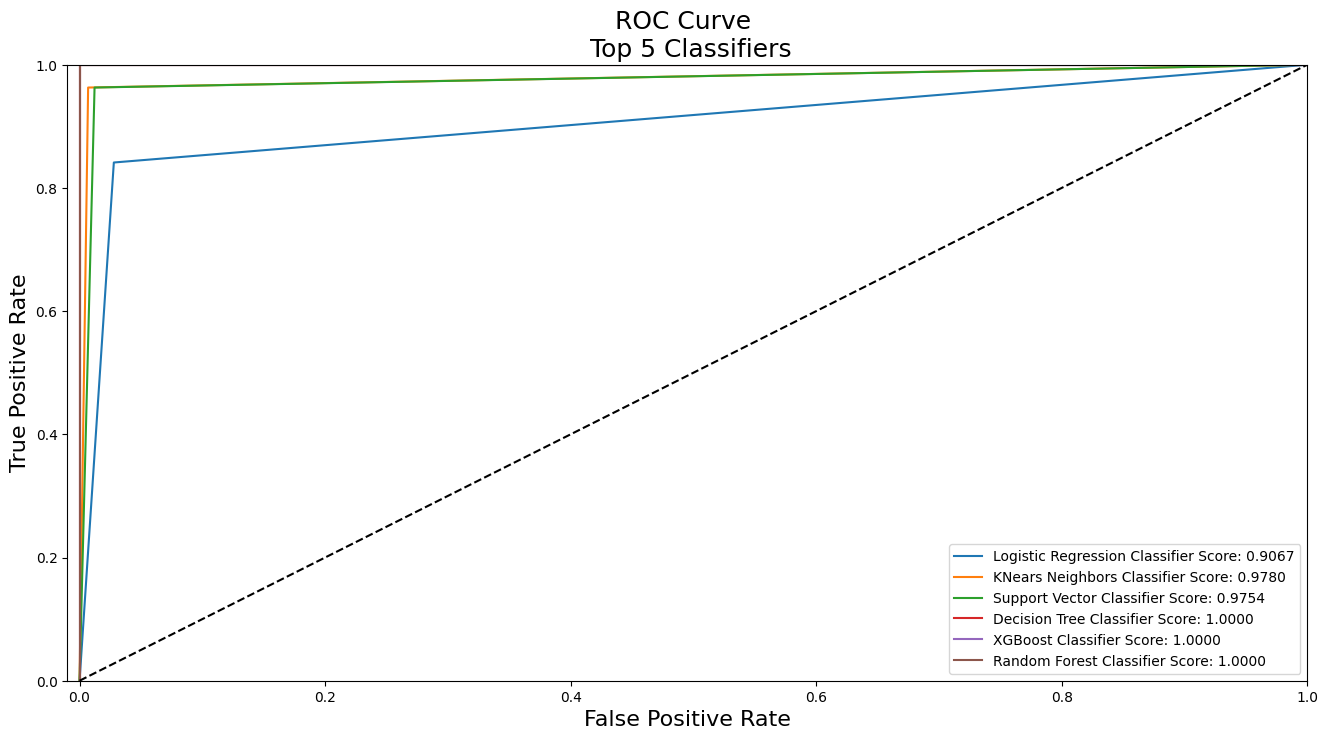

In [133]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_train, xgb_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rf_pred)



def graph_roc_curve_multiple():
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 5 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train, xgb_pred)))
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()
    
graph_roc_curve_multiple()
plt.show()

In [134]:
xgb_pred_test = results_table.iloc[4][2].predict(X_test)

In [116]:
xgb_pred_test = y_pred

Average precision-recall score: 1.00


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =1.00')

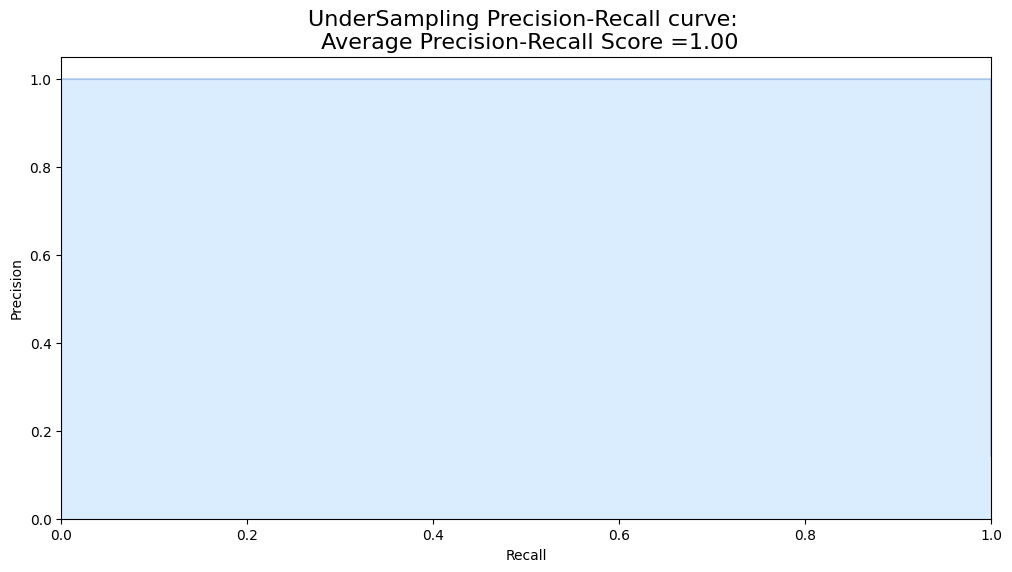

In [135]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, xgb_pred_test)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, xgb_pred_test)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [136]:
from sklearn.metrics import classification_report


print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      1.00      1.00        94

    accuracy                           1.00       659
   macro avg       1.00      1.00      1.00       659
weighted avg       1.00      1.00      1.00       659



Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[565   0]
 [  0  94]]
ROC AUC Score: 1.0


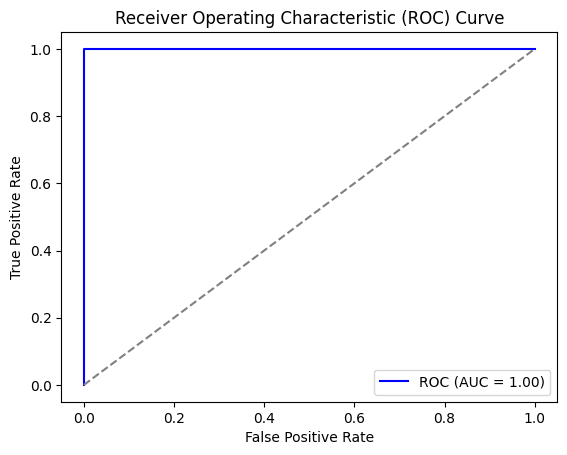

In [137]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 计算各种性能指标
accuracy = accuracy_score(y_test, xgb_pred_test)
precision = precision_score(y_test, xgb_pred_test)
recall = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
conf_matrix = confusion_matrix(y_test, xgb_pred_test)
roc_auc = roc_auc_score(y_test, xgb_pred_test)

# 打印性能指标
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"ROC AUC Score: {roc_auc}")

# 绘制 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred_test)
plt.plot(fpr, tpr, color='blue', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

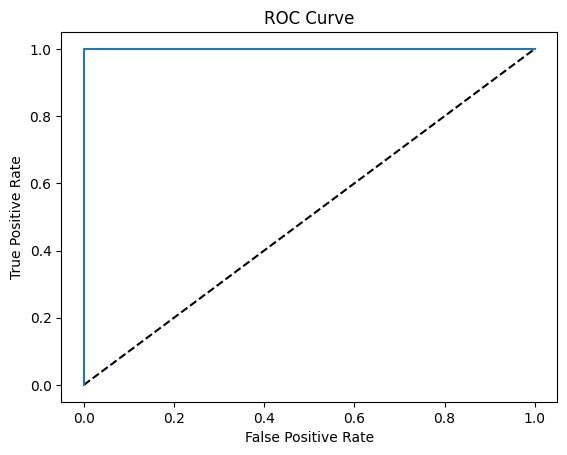

In [138]:
y_pred_prob = results_table.iloc[4][2].predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [160]:
feature_importances = results_table.iloc[4][2].get_booster().get_score(importance_type='weight')

# Print feature importances
print("Feature Importances:")
for feature, importance in feature_importances.items():
    print(train.drop('default',axis= 1).columns[int(feature[-1])]," : ",importance)

Feature Importances:
income  :  3.0
age  :  22.0
loan  :  15.0
ratio  :  27.0
difference  :  16.0


In [153]:
data.columns.difference(['default'])

Index(['age', 'difference', 'income', 'loan', 'ratio'], dtype='object')

In [158]:
train.drop('default',axis=1).columns

Index(['income', 'age', 'loan', 'ratio', 'difference'], dtype='object')

In [156]:
X_train

array([[-0.99859461,  0.43374774, -0.58106462, -0.19726781,  0.95069137],
       [-0.2909123 , -1.38115791,  0.86762287,  1.28826823,  0.51099054],
       [ 1.43807935, -0.00337944, -0.57755921, -0.99604633, -1.68832021],
       ...,
       [ 1.10516832, -1.19156568, -0.86038073, -1.18402698, -1.39149092],
       [-1.23413441, -0.86570704, -0.18406724,  0.75565307,  1.29547082],
       [-1.23885474, -1.63012746, -0.70705829, -0.24908832,  1.18254293]])

In [159]:
train.drop('default',axis= 1)

,income,age,loan,ratio,difference
clientid,,,,,
927,30608.94324,46.476704,2632.551811,0.086006,-27976.391429
751,40836.58881,22.168263,6994.487801,0.171280,-33842.101009
1538,65824.51566,40.621920,2643.106432,0.040154,-63181.409228
1474,59475.49718,36.737130,2628.262124,0.044191,-56847.235056
1010,35620.41863,40.824674,3611.295903,0.101383,-32009.122727
...,...,...,...,...,...
347,69566.68435,52.967088,9875.037183,0.141951,-59691.647167
1929,25379.91548,24.929087,4693.111697,0.184914,-20686.803783
987,61013.18158,24.707619,1791.542962,0.029363,-59221.638618


In [218]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV



# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(X_train, y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    std = StandardScaler()
    X_train_batch = std.fit_transform(X_train.iloc[train])
    X_test_batch = std.fit_transform(X_train.iloc[test])
    model = pipeline.fit(X_train_batch, y_train.iloc[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(X_test_batch)
    
    accuracy_lst.append(pipeline.score(X_test_batch, y_train.iloc[test]))
    precision_lst.append(precision_score(y_train.iloc[test], prediction))
    recall_lst.append(recall_score(y_train.iloc[test], prediction))
    f1_lst.append(f1_score(y_train.iloc[test], prediction))
    auc_lst.append(roc_auc_score(y_train.iloc[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9387755102040817
precision: 0.7108433734939759
recall: 0.9516129032258065
f1: 0.8137931034482758
---------------------------------------------------------------------------------------------------------------------------------------


In [265]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

              precision    recall  f1-score   support

  No Default       0.99      0.91      0.95       565
     Default       0.64      0.97      0.77        94

    accuracy                           0.92       659
   macro avg       0.82      0.94      0.86       659
weighted avg       0.94      0.92      0.92       659

Average precision-recall score: 0.93


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.93')

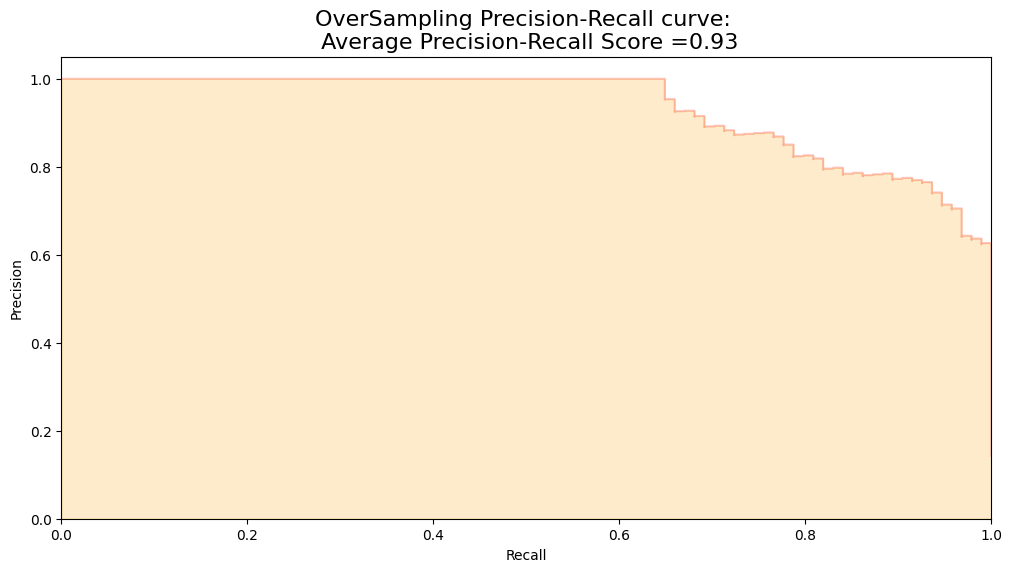

In [221]:
labels = ['No Default', 'Default']
smote_prediction = best_est.predict(X_test)
print(classification_report(y_test, smote_prediction, target_names=labels))

y_score = best_est.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [252]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV



# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()


knears_params = {"n_neighbors": list(range(2,10,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}


rand_log_reg = RandomizedSearchCV(KNeighborsClassifier(), knears_params, n_iter=10)

# log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# knears_params = {"n_neighbors": list(range(2,7,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

for train, test in sss.split(X_train, y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    std = StandardScaler()
    X_train_batch = std.fit_transform(X_train.iloc[train])
    X_test_batch = std.fit_transform(X_train.iloc[test])
    model = pipeline.fit(X_train_batch, y_train.iloc[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(X_test_batch)
    
    accuracy_lst.append(pipeline.score(X_test_batch, y_train.iloc[test]))
    precision_lst.append(precision_score(y_train.iloc[test], prediction))
    recall_lst.append(recall_score(y_train.iloc[test], prediction))
    f1_lst.append(f1_score(y_train.iloc[test], prediction))
    auc_lst.append(roc_auc_score(y_train.iloc[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9659863945578231
precision: 0.8309859154929577
recall: 0.9516129032258065
f1: 0.887218045112782
---------------------------------------------------------------------------------------------------------------------------------------


In [253]:
best_est

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2)

In [266]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [267]:
best_est.fit(Xsm_train, ysm_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2)

              precision    recall  f1-score   support

  No Default       0.99      0.99      0.99       565
     Default       0.95      0.94      0.94        94

    accuracy                           0.98       659
   macro avg       0.97      0.96      0.97       659
weighted avg       0.98      0.98      0.98       659

Average precision-recall score: 0.89


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.89')

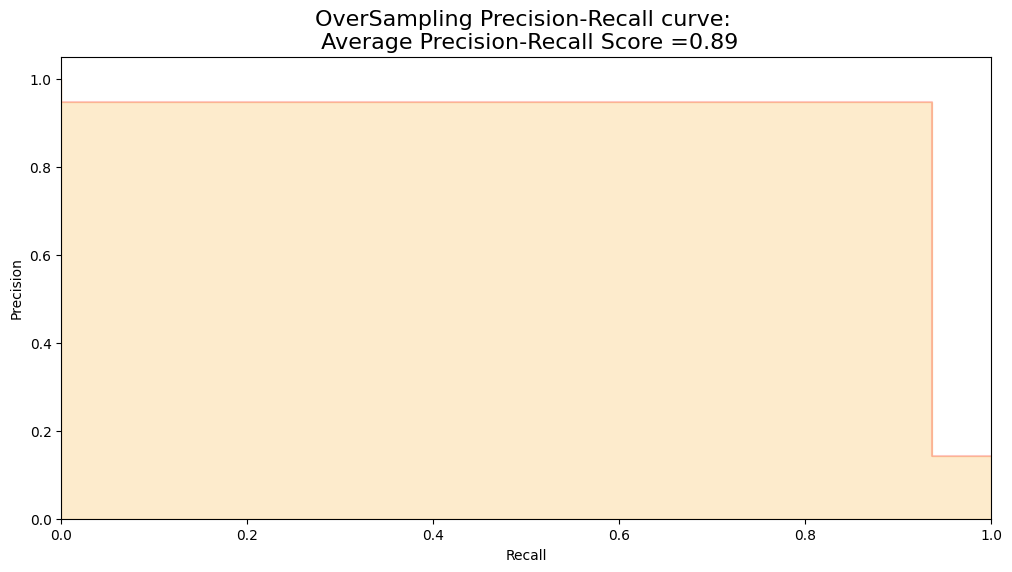

In [268]:
labels = ['No Default', 'Default']
smote_prediction = best_est.predict(X_test)
print(classification_report(y_test, smote_prediction, target_names=labels))

y_score = best_est.predict(X_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)